In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import matplotlib.patches as patches

In [2]:
data_folder = 'dataset/ILSVRC/Data/CLS-LOC'
synset_file = 'dataset/LOC_synset_mapping.txt'

In [20]:
annotations_dict_train = np.load('reduced_dataset/annotations_train.npy').flat[0]
annotations_dict_val = np.load('reduced_dataset/annotations_val.npy').flat[0]

In [4]:
def get_class_names_map():
    f = open(synset_file,'r')
    synset_lines = f.readlines()
    f.close()
    synset_dict = {}
    for line in synset_lines:
        key = line.replace('\n','').split()[0]
        synset_dict[key] = line.replace('\n','').replace(key, '').strip()
    return synset_dict

In [5]:
synset_dict = get_class_names_map()

n04487081
trolleybus, trolley coach, trackless trolley
435


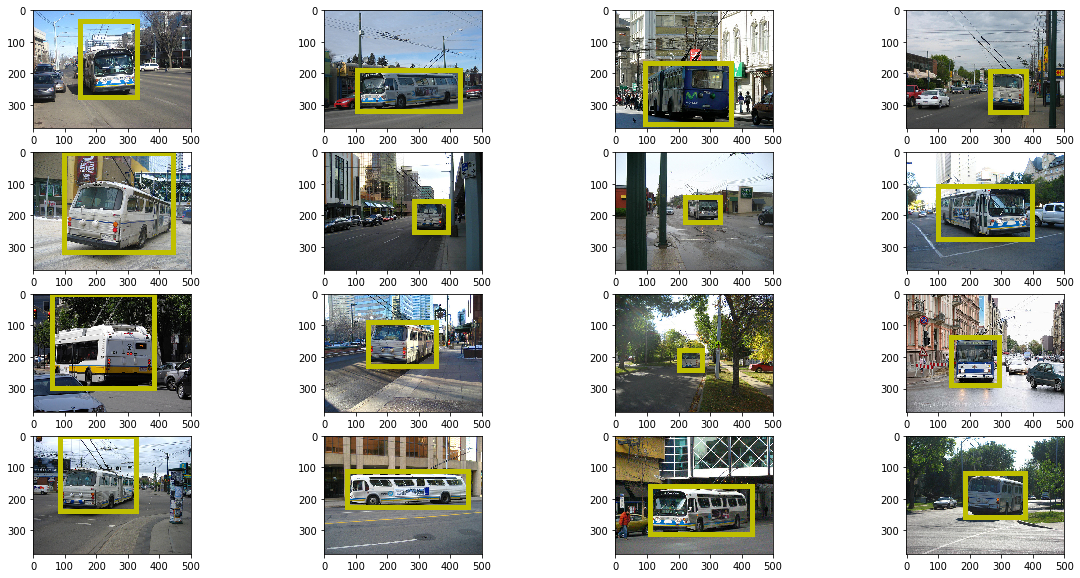

In [6]:
img_class = list(annotations_dict.keys())[0]
print(img_class)
print(synset_dict[img_class])
image_filenames = list(annotations_dict[img_class].keys())
print(len(image_filenames))

fig, axs = plt.subplots(4,4, figsize=(20,10))
axs = axs.flatten()
for i, image_file_id in enumerate(image_filenames[:16]):
    image_file = data_folder+'/train/'+img_class+'/' +image_file_id+'.JPEG'
    image = Image.open(image_file)
    axs[i].imshow(image)
    bounding_box = annotations_dict[img_class][image_file_id]['bounding_boxes'][0]

    rect = patches.Rectangle(bounding_box[:2],bounding_box[2]-bounding_box[0],bounding_box[3]-bounding_box[1],linewidth=5, edgecolor='y',facecolor='none')
    axs[i].add_patch(rect)
plt.show()

In [7]:
idx_2_class = {}
class_2_idx = {}
images_file_list = []
class_list = []

# Armo carpentas con clases

In [19]:
train_folder = 'reduced_dataset/images/train'
val_folder = 'reduced_dataset/images/val'

In [9]:
import os
from shutil import copyfile, rmtree

In [26]:
for class_id in list(class_2_idx.keys()):
    folder_to_create_train = train_folder+'/'+class_id
    folder_to_create_val = val_folder+'/'+class_id
    if (os.path.isdir(folder_to_create_train)):
        rmtree(folder_to_create_train)
    if (os.path.isdir(folder_to_create_val)):
        rmtree(folder_to_create_val)
    os.mkdir(folder_to_create_train)
    os.mkdir(folder_to_create_val)

In [27]:
# Para train
class_list = []
images_file_list = []
for i, (class_id, v) in enumerate(annotations_dict.items()):
    print(i)
    idx_2_class[i] = class_id
    class_2_idx[class_id] = i
    for image_file_id in v:
        class_list.append(i)
        image_file = data_folder+'/train/'+class_id+'/' +image_file_id+'.JPEG'
        images_file_list.append(image_file)
        #print(image_file)
        copyfile(image_file, train_folder+'/'+class_id+'/' +image_file_id+'.JPEG')

0
1
2
3
4
5
6
7
8
9


In [28]:
# Para val
class_list = []
images_file_list = []
for i, (class_id, v) in enumerate(annotations_dict_val.items()):
    print(i)
    idx_2_class[i] = class_id
    class_2_idx[class_id] = i
    for image_file_id in v:
        class_list.append(i)
        image_file = data_folder+'/val/' +image_file_id+'.JPEG'
        images_file_list.append(image_file)
        #print(image_file)
        copyfile(image_file, val_folder+'/'+class_id+'/' +image_file_id+'.JPEG')

0
1
2
3
4
5
6
7
8
9


In [12]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [835]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [836]:
batch_size = 10
train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(375, 500),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3089 images belonging to 10 classes.


In [851]:
from  keras.utils import Sequence
class GeneratorMultipleOutputs(Sequence):
    def __init__(self, generator, annotations_dict):
        self.annotations_dict = annotations_dict
        self.generator = generator
    def get_image_object_center(self):
        bboxes = []
        batch_index = self.generator.batch_index
        if self.generator.batch_index == 0:
            batch_index = self.__len__()
        batch_filenames = np.array(self.generator.filenames)[self.generator.index_array][(batch_index-1)*self.generator.batch_size:batch_index*self.generator.batch_size]
        #print(self.generator.batch_index, self.generator.total_batches_seen, len(batch_filenames), batch_index)
        for filename in batch_filenames:
            arr = filename.split('/')
            class_id = arr[0]
            image_idx = arr[1].split('.')[0]
            bboxes.append(self.annotations_dict[class_id][image_idx]['bounding_boxes'][0])
        bboxes = np.array(bboxes)
        img_width = self.annotations_dict[class_id][image_idx]['width']
        img_height = self.annotations_dict[class_id][image_idx]['height']
        box_width = bboxes[:,2]-bboxes[:,0]
        box_height = bboxes[:,3]-bboxes[:,1]
        centerX = (bboxes[:,0]+(box_width)/2)/img_width
        centerY = (bboxes[:,1]+(box_height)/2)/img_height
        return centerX, centerY, box_width/img_width, box_height/img_height
    def __len__(self):
        return int(np.ceil(self.generator.samples / float(self.generator.batch_size)))
    def __getitem__(self, idx):
        data = next(self.generator)
        centerX, centerY, width, height = self.get_image_object_center()
        return (data[0], [data[1], centerX, centerY, width, height])
    def __next__(self):
        return self.__getitem__(0)
    def __iter__(self):
        return self

In [852]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(train_generator, annotations_dict_train)

In [853]:
#while True:
#    next(train_generator_multiple_outputs)

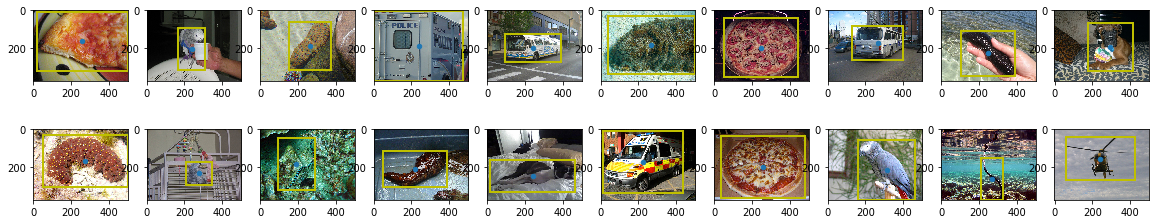

In [864]:
i = 0
N = 2
f, ax = plt.subplots(N, train_generator.batch_size, figsize=(20, 2*N))
for batch in train_generator_multiple_outputs:
    #title = list(map(index_to_class_name.get, np.argmax(batch[1][0], axis = 1)))
    centerX, centerY, width, height = batch[1][1:]
    for j, bat in enumerate(batch[0]):
        
        ax[i, j].imshow(bat)
        ax[i, j].scatter(centerX[j]*500, centerY[j]*375, s= 20)
        rect = patches.Rectangle(((centerX[j]-width[j]/2)*500, (centerY[j]-height[j]/2)*375),width[j]*500,height[j]*375,linewidth=2, edgecolor='y',facecolor='none')
        ax[i, j].add_patch(rect)
    i += 1
    if i >= N:
        break
plt.show()

In [865]:
batch_size = 64
train_generator = train_datagen.flow_from_directory(
    directory=train_folder,
    target_size=(375, 500),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 3089 images belonging to 10 classes.


In [866]:
batch_size = 64
val_generator = val_datagen.flow_from_directory(
    directory=val_folder,
    target_size=(375, 500),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

Found 237 images belonging to 10 classes.


In [867]:
train_generator_multiple_outputs = GeneratorMultipleOutputs(train_generator, annotations_dict_train)
val_generator_multiple_outputs = GeneratorMultipleOutputs(val_generator, annotations_dict_val)

In [868]:
def get_layer(x, filters = 32, filter_size = (3,3), pool_size=(2,2)):
    conv = Conv2D(filters, filter_size)(x)
    BN = BatchNormalization()(conv)
    act = Activation('relu')(BN)
    out = MaxPooling2D(pool_size=pool_size)(act)
    # DO1 = Dropout(0.25)(maxPool1)
    return out

In [869]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization
from keras.models import Model
from keras.constraints import max_norm

def get_simple_model(input_shape=(375, 500, 3)):
    x = Input(shape=(375, 500, 3))
    l1 = get_layer(x, filters = 32, filter_size = (3,3), pool_size=(2,2))
    
    l2 = get_layer(l1, filters = 64, filter_size = (3,3), pool_size=(2,2))
    
    l3 = get_layer(l2, filters = 128, filter_size = (3,3), pool_size=(2,2))
    
    l4 = get_layer(l3, filters = 256, filter_size = (3,3), pool_size=(2,2))
    
    l5 = get_layer(l4, filters = 512, filter_size = (3,3), pool_size=(2,2))

    GAP = GlobalAveragePooling2D()(l5)
    #last_layer = Dropout(0.25)(GAP)
    return GAP, x
last_layer, input_layer = get_simple_model()

In [879]:
classes = 10
classification = Dense(classes, activation='softmax', name='category_output')(last_layer) #kernel_constraint=max_norm(2.)
regression_center_x = Dense(1, name='center_x')(last_layer)
regression_center_y = Dense(1, name='center_y')(last_layer)
regression_width = Dense(1, name='width')(last_layer)
regression_height = Dense(1, name='height')(last_layer)
model = Model(inputs=input_layer, outputs=[classification, regression_center_x, regression_center_y, regression_width, regression_height])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 375, 500, 3)  0                                            
__________________________________________________________________________________________________
conv2d_292 (Conv2D)             (None, 373, 498, 32) 896         input_54[0][0]                   
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 373, 498, 32) 128         conv2d_292[0][0]                 
__________________________________________________________________________________________________
activation_232 (Activation)     (None, 373, 498, 32) 0           batch_normalization_120[0][0]    
__________________________________________________________________________________________________
max_poolin

In [880]:
from keras.optimizers import Adam

In [881]:
losses = {"category_output": "categorical_crossentropy", 
          "center_x": "mean_squared_error", 
          "center_y": "mean_squared_error",
          "width": "mean_squared_error",
          "height": "mean_squared_error"
         }
metrics = {"category_output": "accuracy", "center_x": "mae", "center_y": "mae", "width": "mae", "height": "mae"}
lossWeights = {"category_output": 1.0, "center_x": 5.0,  "center_y": 5.0, "width": 5.0, "height": 5.0}

In [882]:
model.compile(loss=losses,
              optimizer=Adam(lr=0.001),
              metrics=metrics,
              loss_weights = lossWeights)

In [ ]:
model.fit_generator(
        train_generator_multiple_outputs,
        #steps_per_epoch=steps_per_epoch,
        epochs=200,
        validation_data=val_generator_multiple_outputs)

Epoch 1/200


In [141]:
model.evaluate_generator(val_generator)

[0.8494991622393644, 0.7510548550871354]

In [142]:
model.evaluate_generator(train_generator)

[0.3320881910851257, 0.8685658789638101]